# **Projet 6 : Classifiez automatiquement des biens de consommation - Faisabilité texte+image**

**Table des matières**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
  - 1.1. [Contexte](#toc1_1_)    
  - 1.2. [Mission](#toc1_2_)    
  - 1.3. [Objectif du Notebook](#toc1_3_)    
- 2. [Installation des librairies](#toc2_)    
- 3. [Importation des données](#toc3_)    
- 4. [Combinaison des meilleurs modèles](#toc4_)    
- 5. [Résultats](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introduction](#toc0_)
### 1.1. <a id='toc1_1_'></a>[Contexte](#toc0_)

Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.

Voici certaintes parties du mail envoyé par Linda.

### 1.2. <a id='toc1_2_'></a>[Mission](#toc0_)

1. Ta mission est de réaliser, dans une première itération, une étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

2. Pourrais-tu réaliser une classification supervisée à partir des images ? Je souhaiterais que tu mettes en place une data augmentation afin d’optimiser le modèle.

3. Pourrais-tu tester la collecte de produits à base de “champagne” via l’API Rapid API ? Je souhaiterais que tu puisses nous fournir une extraction des 10 premiers produits dans un fichier “.csv”, contenant pour chaque produit les données suivantes : foodId, label, category, foodContentsLabel, image.

### 1.3. <a id='toc1_3_'></a>[Objectif du Notebook](#toc0_)

Dans ce Notebook nous verrons, la faisablité de clasement de produits en utilisant les deux meilleurs modèles vu précédement en association (texte + image)

## 2. <a id='toc2_'></a>[Installation des librairies](#toc0_)

In [1]:
from fonctions import fct_data, fct_clustering

## 3. <a id='toc3_'></a>[Importation des données](#toc0_)

In [2]:
# Importation des données : 
data = fct_data.chargement_pickle(
    name='data_pretraite_NLP',
    chemin='2. Sauvegardes/1. NLP',
)
dict_desc_class_non_supervisee = fct_data.chargement_pickle(
    name='dict_desc_class_non_supervisée', 
    chemin='2. Sauvegardes/1. NLP',
)

dict_img_class_non_supervisee = fct_data.chargement_pickle(
    name='dict_img_class_non_supervisee',
    chemin='2. Sauvegardes/2. IMAGE',
)

In [4]:
# Création d'un dictionnaire commun : 

dict_final_results_class_non_supervisee = dict_desc_class_non_supervisee.copy()
dict_final_results_class_non_supervisee.update(dict_img_class_non_supervisee)

print(f"Résultats présent dans le ductionnaire final : \n")

for key in dict_final_results_class_non_supervisee.keys(): 
    print(f"\t- {key}")

# Enregistrement : 
fct_data.enregistrement_pickle(
    name='dict_final_results_class_non_supervisee', 
    chemin='2. Sauvegardes', 
    fichier=dict_final_results_class_non_supervisee,
)

del dict_desc_class_non_supervisee, dict_img_class_non_supervisee, key

Résultats présent dans le ductionnaire final : 

	- bow_CV_desc_cleaned_lem
	- bow_CV_desc_cleaned_stem
	- bow_Tfidf_desc_cleaned_lem
	- bow_Tfidf_desc_cleaned_stem
	- w2v_CBOW_desc_tokenise
	- w2v_CBOW_desc_tokenise_without_sw
	- w2v_Sg_desc_tokenise
	- w2v_Sg_desc_tokenise_without_sw
	- d2v_PVDBOW_desc_tokenise
	- d2v_PVDBOW_desc_tokenise_without_sw
	- d2v_PVDM_desc_tokenise
	- d2v_PVDM_desc_tokenise_without_sw
	- DistilBERT_base_uncased_desc_brut
	- DistilBERT_base_uncased_ft_SST2_desc_brut
	- RoBERTa_Large_desc_brut
	- USE_v4
	- USE_Large_v5
	- SIFT_image_pretraitee
	- VGG16_image_brut
	- ResNet_152_v1_image_brut
	- ResNet_152_v2_image_brut
	- InceptionNet_v3_image_brut
	- InceptionNet_ResNet_image_brut


## 4. <a id='toc4_'></a>[Combinaison des meilleurs modèles](#toc0_)
Utilisation de USE_Large_v5 et ResNet_152_v1

In [6]:
# Création d'un DataFrame de vectorisation combiné : 

# Récupération des embeddings des description avec USE_Large_v5 : 
df_USE_large_v5 = dict_final_results_class_non_supervisee['USE_Large_v5']['df_vectorisation'].copy()
df_USE_large_v5 = df_USE_large_v5.drop(['Category_true', 'Category_predict'], axis=1)

# Récupération des features des images avec ResNet_152_v1 : 
df_ResNet_152_v1 = dict_final_results_class_non_supervisee['ResNet_152_v1_image_brut']['df_vectorisation'].copy()
df_ResNet_152_v1 = df_ResNet_152_v1.drop(['Category_true', 'Category_predict'], axis=1)

# Création de df (merge entre les deux précédent df_vectorisation) : 
df = df_ResNet_152_v1.merge(df_USE_large_v5, left_index=True, right_index=True)
X = df.values

print(f"Dimension du DataFrame de vectorisation : {df.shape}")

del df_ResNet_152_v1, df_USE_large_v5

Dimension du DataFrame de vectorisation : (1050, 100864)


----------------------------------------------------------------------------------------------------
Projections en 2D avec réduction TSNE en fonction de la perplexité


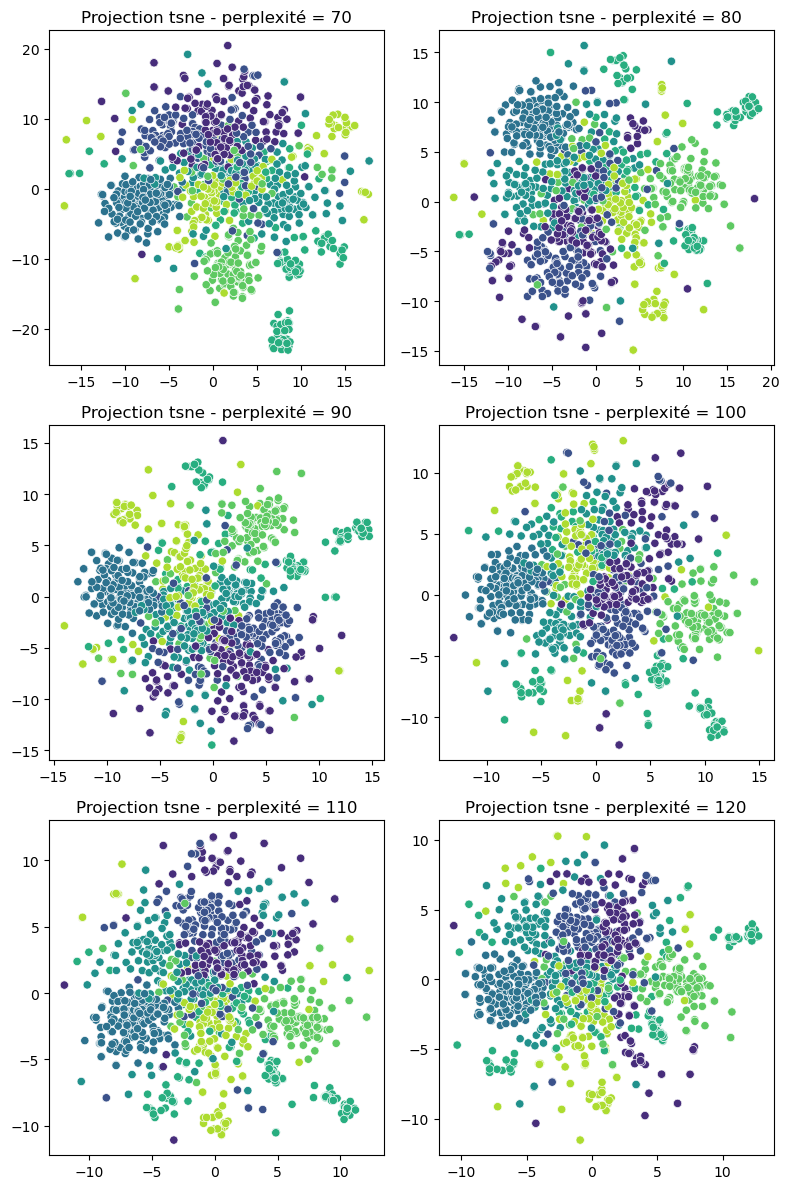

----------------------------------------------------------------------------------------------------
Meilleure perplexité de TSNE : 90
----------------------------------------------------------------------------------------------------
Meilleurs paramètres de KMeans : {'n_clusters': 7, 'random_state': 42, 'n_init': 10, 'max_iter': 100}


,coef_silh,dispersion,davies_bouldin
1,0.38637,13107.814453,0.812859


----------------------------------------------------------------------------------------------------
Score ARI du clustering : 0.3868
Homogénéité : 0.46945626275542673
Complétude : 0.48271489362612485
V-measure : 0.47599326742742865
----------------------------------------------------------------------------------------------------
Comparaison des projections du clustering vs catégories réelles
->
COMBI_USE_largev5_ResNet_152v1
----------------------------------------------------------------------------------------------------


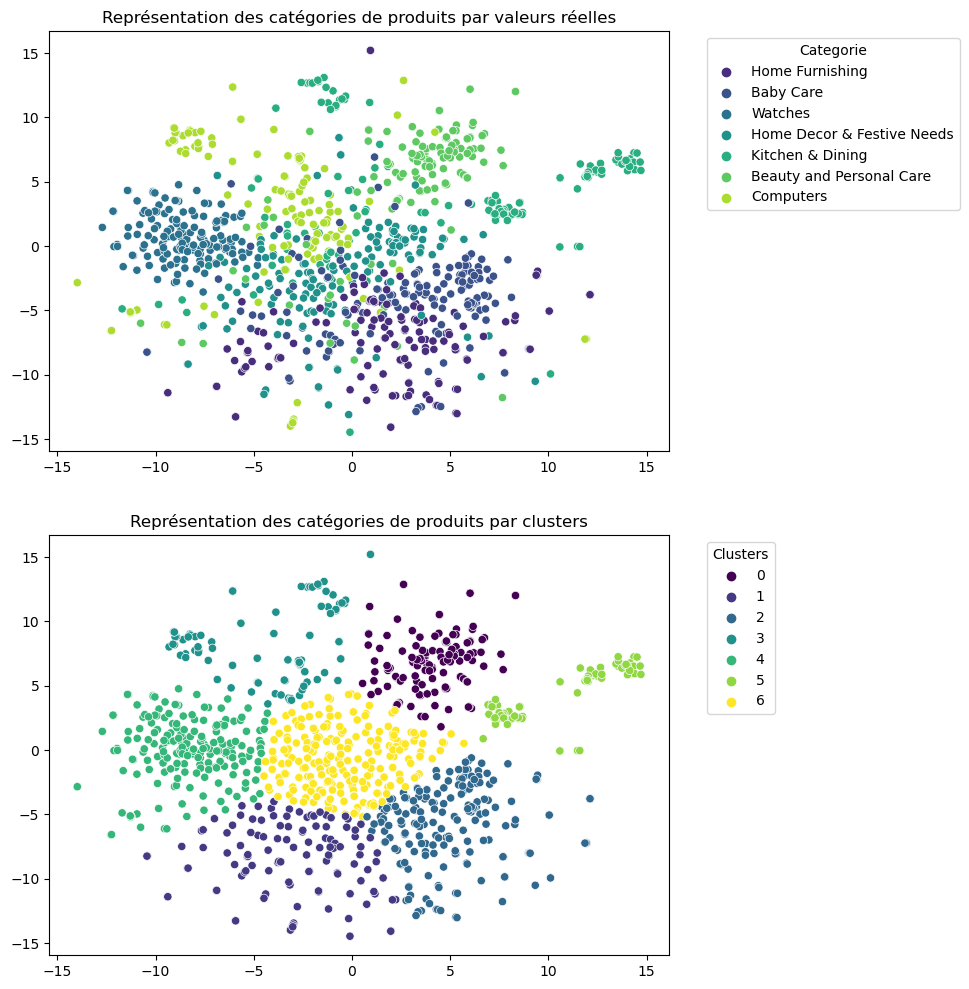

In [7]:
# Clustering 

kmeans_params, tsne_perplexity, labels, dict_result = \
    fct_clustering.best_clustering(
        features=X, 
        y_true=data['category_cleaned'],
        tsne_perplexity_range=[70, 80, 90, 100, 110 , 120],
        kmeans_clusters=data['category_cleaned'].nunique(),
        ls_ninit=[10, 20, 30, 50, 70, 80, 100],
        ls_maxiter=[100, 200, 300, 400, 500],
        title='COMBI_USE_largev5_ResNet_152v1', 
        )

In [8]:
# Enregistrement des résultats : 

# 1. Complétion de df : 
df['Category_true'] = data['category_cleaned']
df['Category_predict'] = labels

 # 2. Stockage des données : 
dict_final_results_class_non_supervisee['COMBI_USE_largev5_ResNet_152v1'] = {
    'df_vectorisation': df,
    'kmeans_best_params': kmeans_params,
    'TSNE_perplexity' : tsne_perplexity,
    'clustering_result' : dict_result
}

# 3. Enregistrement du dictionnaire au format pickle : 
fct_data.enregistrement_pickle(
    name='dict_final_results_class_non_supervisee',
    chemin='2. Sauvegardes',
    fichier=dict_final_results_class_non_supervisee,
    )

del X, df, labels, kmeans_params, tsne_perplexity, dict_result

## 5. <a id='toc5_'></a>[Résultats](#toc0_)

In [3]:
# Chargement des données :
dict_final_results_class_non_supervisee = fct_data.chargement_pickle(
    name='dict_final_results_class_non_supervisee',
    chemin='2. Sauvegardes'
)

dict_desc_class_non_supervisee = fct_data.chargement_pickle(
    name='dict_desc_class_non_supervisée',
    chemin='2. Sauvegardes/1. NLP'
)

dict_img_class_non_supervisee = fct_data.chargement_pickle(
    name='dict_img_class_non_supervisee',
    chemin='2. Sauvegardes/2. IMAGE'
)

In [4]:
# Ajout dans le dictionnaire final de la variable type de donnée : 

len_texte = len(dict_desc_class_non_supervisee)
len_image = len(dict_img_class_non_supervisee)

for indice, key in enumerate(dict_final_results_class_non_supervisee.keys()):
    if indice < len_texte: 
        dict_final_results_class_non_supervisee[key]['type_donnees'] = 'TEXTE'
    elif len_texte <= indice < len_texte + len_image:
        dict_final_results_class_non_supervisee[key]['type_donnees'] = 'IMAGE'
    else: 
        dict_final_results_class_non_supervisee[key]['type_donnees'] = 'COMBI T+I'

fct_data.enregistrement_pickle(
    name='dict_final_results_class_non_supervisee',
    chemin='2. Sauvegardes',
    fichier=dict_final_results_class_non_supervisee,
)

del len_image, len_texte, indice, key
del dict_img_class_non_supervisee, dict_desc_class_non_supervisee

,Accuracy,ARI,Homogénéité,Complétude,V-measure,Type_donnee
Modèle,,,,,,
USE_Large_v5,0.75,0.57,0.65,0.66,0.66,TEXTE
bow_Tfidf_desc_cleaned_lem,0.75,0.53,0.60,0.61,0.60,TEXTE
bow_Tfidf_desc_cleaned_stem,0.72,0.47,0.57,0.59,0.58,TEXTE
USE_v4,0.65,0.44,0.57,0.57,0.57,TEXTE
bow_CV_desc_cleaned_stem,0.65,0.40,0.50,0.51,0.50,TEXTE
bow_CV_desc_cleaned_lem,0.64,0.40,0.49,0.51,0.50,TEXTE
COMBI_USE_largev5_ResNet_152v1,0.61,0.39,0.47,0.48,0.48,COMBI T+I
InceptionNet_ResNet_image_brut,0.61,0.37,0.43,0.44,0.43,IMAGE
ResNet_152_v1_image_brut,0.59,0.41,0.48,0.48,0.48,IMAGE


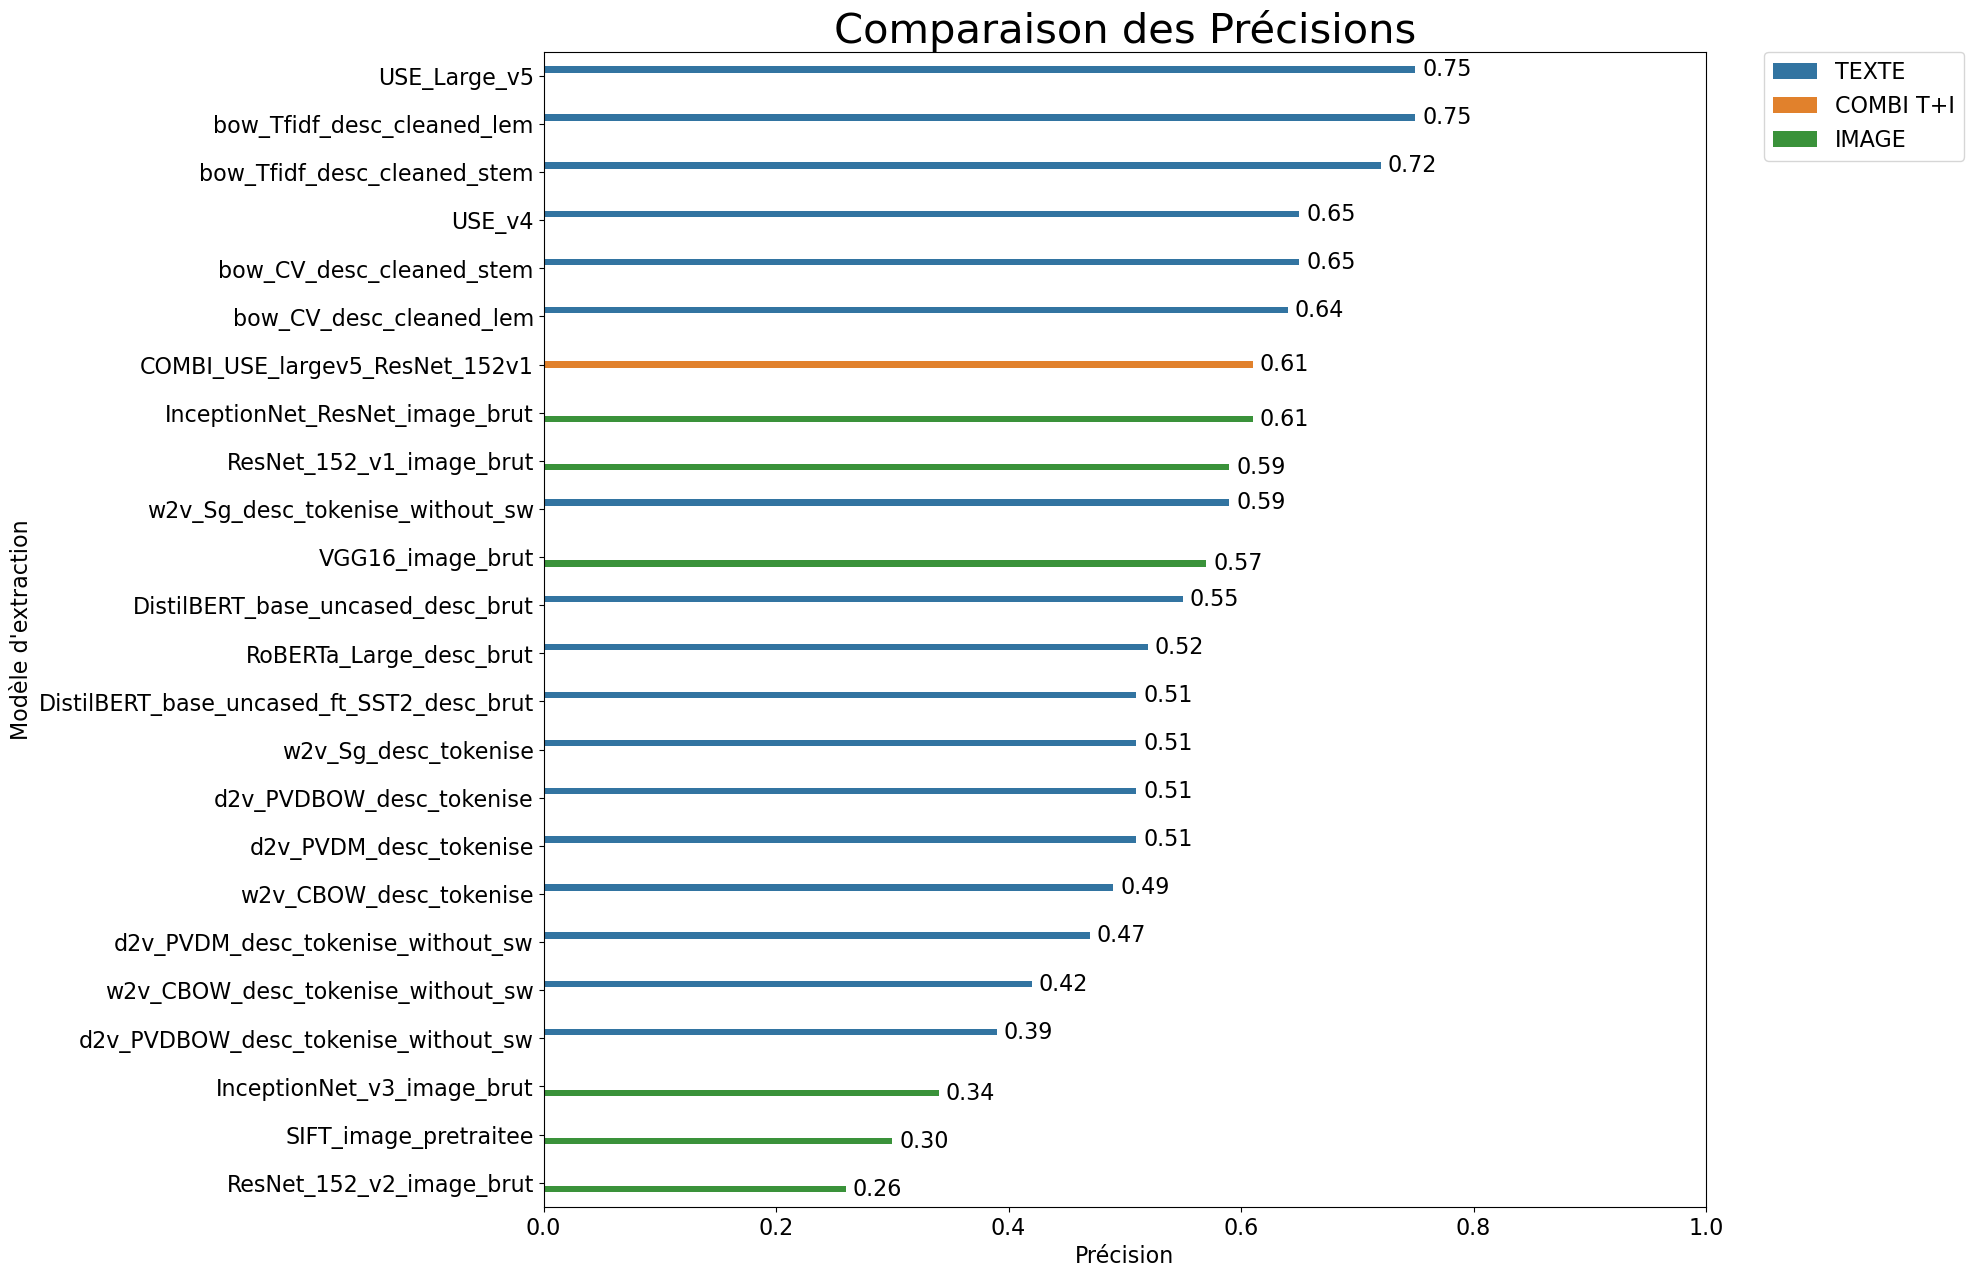

In [5]:
# Visualisation du classement total : 
df_result = fct_clustering.classement_final(
    dico=dict_final_results_class_non_supervisee,
)

fct_data.enregistrement_pickle(
    name='data_final_class_non_supervisee',
    chemin='2. Sauvegardes',
    fichier= df_result,
)

Comme on peut le constater, en utilisant une classification non supervisée : 
- La meilleure précision atteinte est de 75 % 
- Les résultats se dégrade en utilisant uniquement une catégorisation par les images et/ou image+description.

        --> Meilleur résultat : Classification non supervisée sur les embeddings des description avec USE_Large_v5.


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                                                                   1. USE_Large_v5                                                                    
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
----------------------------------------------------------------------------------------------------
Comparaison des projections du clustering vs catégories réelles
->
Tsne perplexité : 20
----------------------------------------------------------------------------------------------------


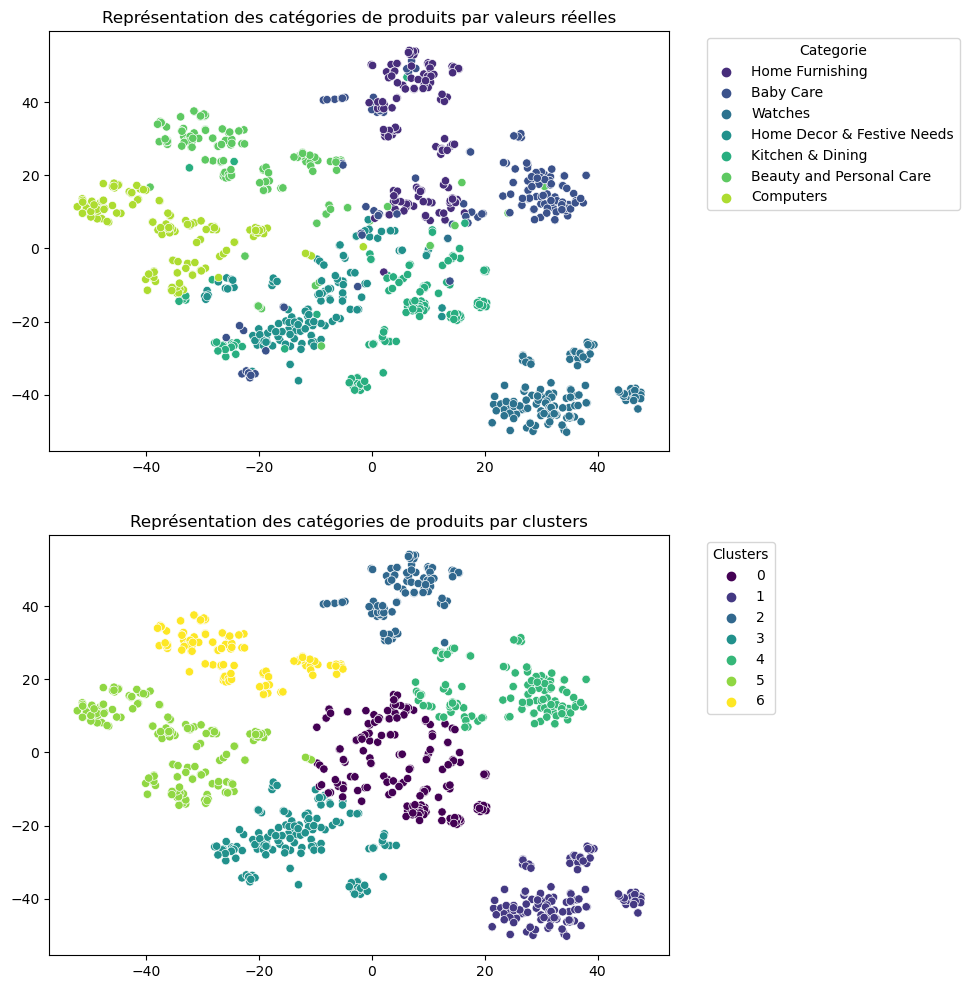

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                                                            2. bow_Tfidf_desc_cleaned_lem                                                             
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
----------------------------------------------------------------------------------------------------
Comparaison des projections du clustering vs catégories réelles
->
Tsne perplexité : 30
----------------------------------------------------------------------------------------------------


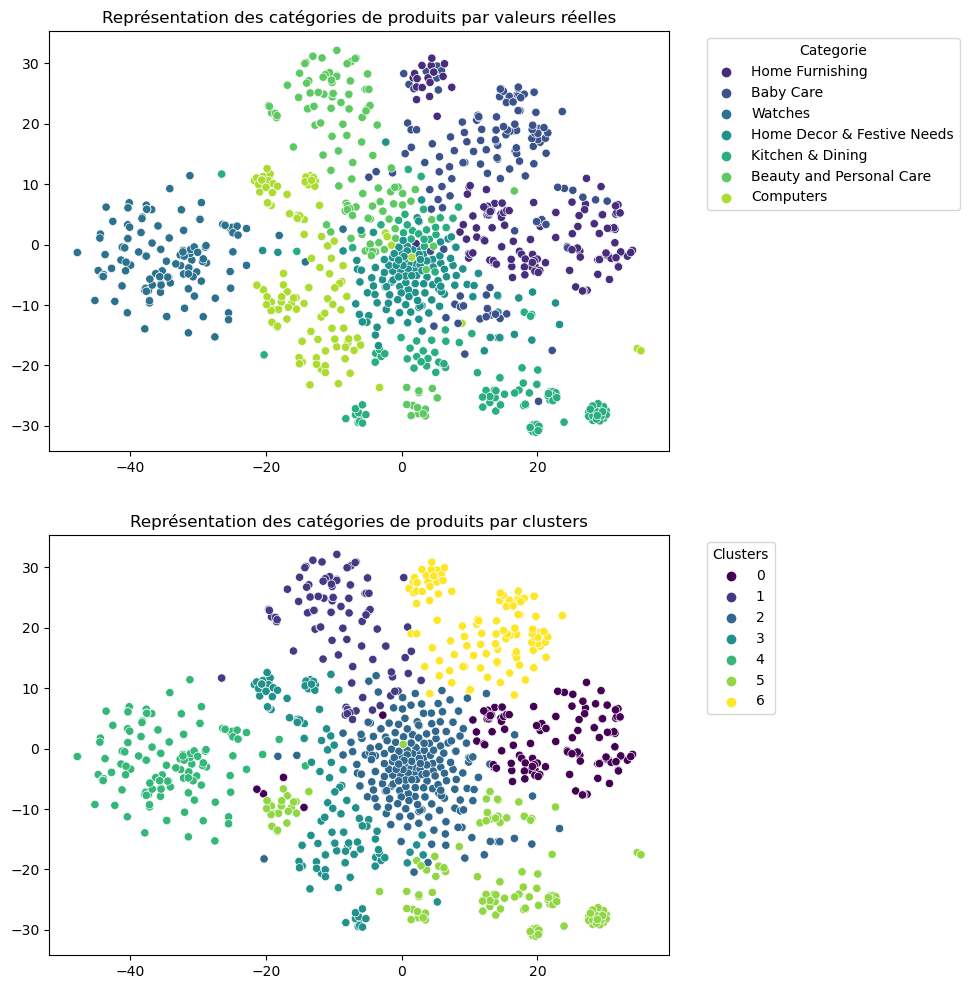

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                                                            3. bow_Tfidf_desc_cleaned_stem                                                            
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
----------------------------------------------------------------------------------------------------
Comparaison des projections du clustering vs catégories réelles
->
Tsne perplexité : 30
----------------------------------------------------------------------------------------------------


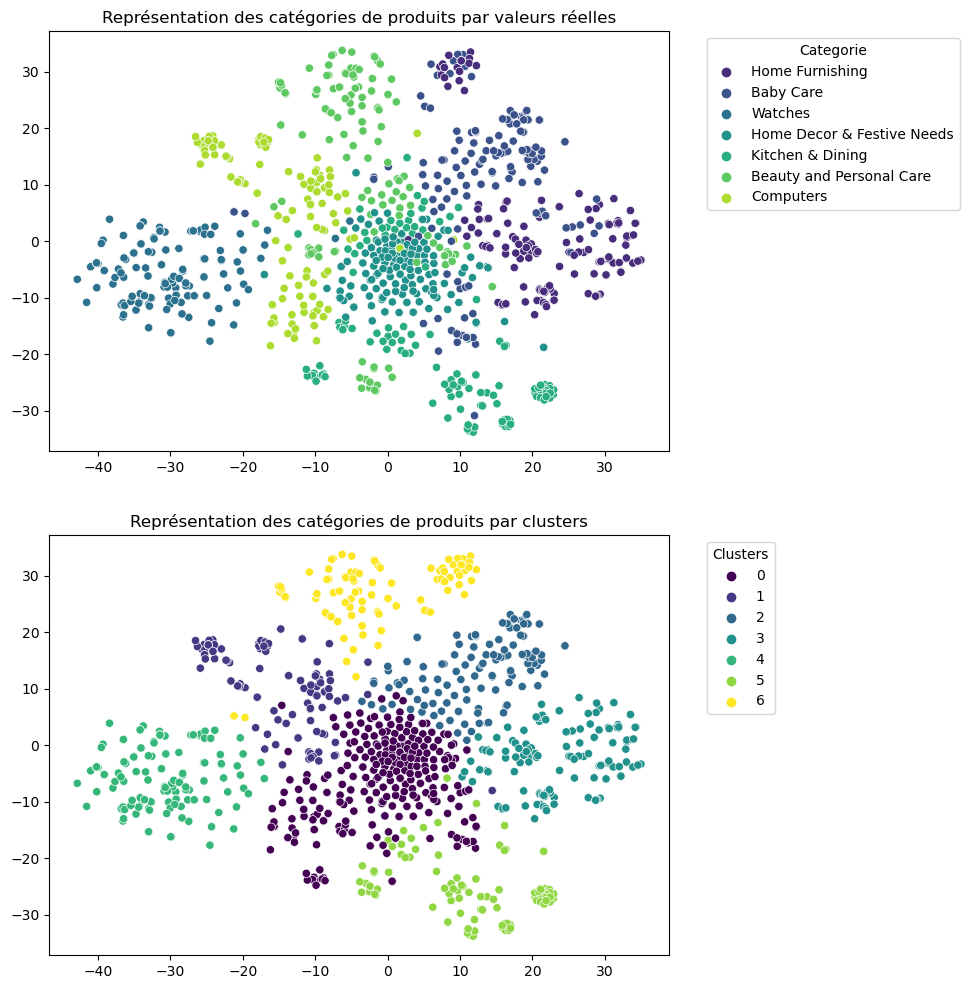

In [6]:
# Visualisation des projections des 3 meilleurs clusterings : 

for i, model in enumerate(df_result.head(3).index): 
    
    # 1. Titre : 
    titre = f"{i+1}. {model}"
    print('++'*75)
    print(titre.center(150))
    print('++'*75)
    
    # 2. Projection : 
    df = dict_final_results_class_non_supervisee[model]['df_vectorisation'].copy()
    
    X_tsne = fct_clustering.proj_tsne(
        features=df.iloc[:,:-2].values,
        tsne_perplexity=dict_final_results_class_non_supervisee[model]['TSNE_perplexity']
    )
    
    # 3. visualisation des projections : 
    fct_clustering.visu_clustering(
        X_tsne=X_tsne, 
        y_true=df['Category_true'],
        y_label=df['Category_predict'],
        title=f"Tsne perplexité : {dict_final_results_class_non_supervisee[model]['TSNE_perplexity']}",
    )

del model, X_tsne, titre, i, df
